<a href="https://colab.research.google.com/github/shanw25/STOR566/blob/main/Final_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STOR 566 Final Project

Wei Chen, Rohan Iyer, Sam Ferguson, Gary Zhang

In [1]:
!pip install transformers datasets evaluate
import torch
import numpy as np
import pandas as pd
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
import datasets
import evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.6 MB/s 
     |████████████████████████████████| 451 kB 56.0 MB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 182 kB 81.7 MB/s 
     |████████████████████████████████| 7.6 MB 61.9 MB/s 
     |████████████████████████████████| 115 kB 56.5 MB/s 
     |████████████████████████████████| 212 kB 85.7 MB/s 
     |████████████████████████████████| 127 kB 84.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Pre-trained model

These cells are simply for playing around with the pre-trained model. You don't have to run them to use the later cells.

In [2]:
zero_shot_pipeline = pipeline('zero-shot-classification', model='typeform/distilbert-base-uncased-mnli')

sequences = [
    "I like to dance.",
    "We need healthcare for every American."
]

candidate_labels = [
    "Bernie Sanders would vote for this bill.",
    "Mitt Romney would vote for this.",
    "Mitch McConnell would vote for this bill.",
    "Ronald McDonald would vote for this bill."
]

out = zero_shot_pipeline(sequences, candidate_labels, multi_label = True)

for dictionary in out:
    print(dictionary["sequence"])
    labels = dictionary["labels"]
    scores = dictionary["scores"]
    for k in range(len(labels)):
        # nice formatting for labels and scores
        print("{:<50} {:<7.3f}".format(labels[k], scores[k]))
    print("")

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


I like to dance.
Mitt Romney would vote for this.                   0.051  
Bernie Sanders would vote for this bill.           0.006  
Ronald McDonald would vote for this bill.          0.001  
Mitch McConnell would vote for this bill.          0.000  

We need healthcare for every American.
Bernie Sanders would vote for this bill.           0.138  
Mitt Romney would vote for this.                   0.110  
Mitch McConnell would vote for this bill.          0.066  
Ronald McDonald would vote for this bill.          0.009  



In [3]:
tokenizer = AutoTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")
model     = AutoModelForSequenceClassification.from_pretrained(
    "typeform/distilbert-base-uncased-mnli",
) 

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [4]:
example_seq = tokenizer(
    #"This bill seeks to expand healthcare for working Americans",
    #"A senator who wants to expand healthcare would vote for this bill",
    "This bill will lower the cost of salads", "People who want to pay less for salads will like this bill",
    return_tensors="pt"
)

with torch.no_grad():
    output = model(**example_seq)
    logits = output.logits
    print(output)

predicted_class_id = logits.argmax().item()
print(predicted_class_id)
print(model.config.id2label[predicted_class_id])

SequenceClassifierOutput(loss=None, logits=tensor([[-2.4037,  4.4061, -2.9311]]), hidden_states=None, attentions=None)
1
NEUTRAL


## Data pre-processing

In [20]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = '=17ymGmyUZRtTIPR3Huk47uI6rrM4nD8PG' # The shareable link full

# link = '=1ORr1zjRkRUp0Y8LaKl_C7RYfSDKTUKPi' # The shareable link 2021

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 

downloaded.GetContentFile('SenateVotesFULL.csv')  
# downloaded.GetContentFile('SenateVotes120k.csv')  
# df3 = pd.read_csv('SenateVotesFULL.csv')
# Dataset is now stored in a Pandas Dataframe

17ymGmyUZRtTIPR3Huk47uI6rrM4nD8PG


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
# Pre-process 2021 senate votes dataframe
train_df_2021 = pd.read_csv(
    "SenateVotesFULL.csv",
    # "SenateVotes120k.csv",
    skiprows = 0,
    header = 1
)

train_df_2021 = train_df_2021.drop(columns = "0")

# We can't feed the Policy column directly to the model. We'll remove the part before the column,
# and then we'll transform the Policy string into a complete sentence, which is required for our
# model to perform natural language inference.
def policy_to_NLI_2021(policy_str):
    first_colon_index = policy_str.index(":")
    bill_type = policy_str[:first_colon_index]
    policy_contents = policy_str[first_colon_index + 2:first_colon_index + 3].lower() + policy_str[first_colon_index + 3:]
    
    if bill_type == "Measure Title":
        nli_str  = "This is " + policy_contents
    if bill_type == "Statement of Purpose":
        nli_str  = "This bill serves " + policy_contents
    if bill_type == "Nomination Description":
        nli_str  = ""
    if bill_type == "Treaty Title":
        nli_str  = "This treaty is " + policy_contents

    return nli_str

def get_state(abbreviation):
    states = {"AK": "Alaska", "AL": "Alabama", "AR": "Arkansas", "AS": "American Samoa", "AZ": "Arizona", "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DC": "District of Columbia", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "GU": "Guam", "HI": "Hawaii", "IA": "Iowa", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "MA": "Massachusetts", "MD": "Maryland", "ME": "Maine", "MI": "Michigan", "MN": "Minnesota", "MO": "Missouri", "MP": "Northern Mariana Islands", "MS": "Mississippi", "MT": "Montana", "NA": "National", "NC": "North Carolina", "ND": "North Dakota", "NE": "Nebraska", "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NV": "Nevada", "NY": "New York", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "PR": "Puerto Rico", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VA": "Virginia", "VI": "Virgin Islands", "VT": "Vermont", "WA": "Washington", "WI": "Wisconsin", "WV": "West Virginia", "WY": "Wyoming"}        
    return states[abbreviation]

def get_party(party):
    if   party == "D": return "democrat"
    elif party == "R": return "republican"
    elif party == "I": return "independent"
    else: pass
    
# For senator votes, we drop votes that are "gui" or "pres", then we convert the remainder into
# a Series (aka column) containing integers where yea is 2 and everything else is 0. This corresponds
# to Distilbert MNLI's predefined labels where a label of 2 is CONTRADICTION and 0 is ENTAILMENT. A label
# of 1 corresponds to NEUTRAL, but we aren't using that here.
train_df_2021 = train_df_2021.loc[(train_df_2021["Vote"] != "Gui") & (train_df_2021["Vote"] != "Pres")]
train_df_2021["Vote"] = 2 - pd.Series(train_df_2021["Vote"] == "Yea", dtype = int) * 2

# create an natural language inference (NLI) version of each policy for our model to train on
train_df_2021["Policy_NLI"]  = train_df_2021["Policy"]
# train_df_2021["Policy_NLI"]  = train_df_2021["Policy"].apply(policy_to_NLI_2021)
# change to "name" when only processing 2021 data
train_df_2021["Senator_NLI"] = train_df_2021["SenatorIDName"] + ", a " + \
                               train_df_2021["Party"].apply(get_party) + " from " + \
                               train_df_2021["State"].apply(get_state) + ", would vote for this."

# Drop bills that are nothing more than presidential nominations
train_df_2021 = train_df_2021.loc[train_df_2021["Policy_NLI"] != ""]

display(train_df_2021)

,Year,Bill,SenatorIDName,Party,State,Vote,PolicyID,Policy,Policy_NLI,Senator_NLI
0,2000,1,Sessions,R,AL,2,1,To make an amendment with respect to the disal...,To make an amendment with respect to the disal...,"Sessions, a republican from Alabama, would vot..."
1,2000,1,Shelby,R,AL,2,1,To make an amendment with respect to the disal...,To make an amendment with respect to the disal...,"Shelby, a republican from Alabama, would vote ..."
2,2000,1,Murkowski,R,AK,2,1,To make an amendment with respect to the disal...,To make an amendment with respect to the disal...,"Murkowski, a republican from Alaska, would vot..."
3,2000,1,Stevens,R,AK,2,1,To make an amendment with respect to the disal...,To make an amendment with respect to the disal...,"Stevens, a republican from Alaska, would vote ..."
4,2000,1,Kyl,R,AZ,2,1,To make an amendment with respect to the disal...,To make an amendment with respect to the disal...,"Kyl, a republican from Arizona, would vote for..."
...,...,...,...,...,...,...,...,...,...,...
449766,2022,357,Cantwell,D,WA,2,4667,A bill to repeal the Defense of Marriage Act a...,A bill to repeal the Defense of Marriage Act a...,"Cantwell, a democrat from Washington, would vo..."
449767,2022,357,Murray,D,WA,2,4667,A bill to repeal the Defense of Marriage Act a...,A bill to repeal the Defense of Marriage Act a...,"Murray, a democrat from Washington, would vote..."
449768,2022,357,Capito,R,WV,2,4667,A bill to repeal the Defense of Marriage Act a...,A bill to repeal the Defense of Marriage Act a...,"Capito, a republican from West Virginia, would..."
449769,2022,357,Manchin,D,WV,2,4667,A bill to repeal the Defense of Marriage Act a...,A bill to repeal the Defense of Marriage Act a...,"Manchin, a democrat from West Virginia, would ..."


In [35]:
id = '1VnCRp00c7Ryr_NJK_o6xBdh7DPU-3C9L'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('SenateVotes2022.csv')  
# df3 = pd.read_csv('SenateVotes2022.csv')

In [36]:
train_df_2022 = pd.read_csv(
    "SenateVotes2022.csv",
    skiprows = 0,
    header = 1
)

train_df_2022 = train_df_2022.drop(columns = "0")

# Because Sam used a different scraping technique for 2021 and 2022 senate votes, we use a different
# function for pre-processing policy statements
def policy_to_NLI_2022(policy_str):
    if policy_str[0:2] == "To":
        return "This bill serves to " + policy_str[0].lower() + policy_str[1:]
    else:
        return "This is " + policy_str[0].lower() + policy_str[1:]


train_df_2022["Vote"] = 2 - pd.Series(train_df_2022["Vote"] == "Y", dtype = int) * 2

train_df_2022["Policy_NLI"]  = train_df_2022["Policy"].apply(policy_to_NLI_2022)
train_df_2022["Senator_NLI"] = train_df_2022["Name"] + ", a " + \
                               train_df_2022["Party"].apply(get_party) + " from " + \
                               train_df_2022["State"].apply(get_state) + ", would vote for this."

display(train_df_2022)

,Year,Bill,Name,Party,State,Vote,PolicyID,Policy,Policy_NLI,Senator_NLI
0,2022,8,Shelby,R,AL,0,4549,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Shelby, a republican from Alabama, would vote ..."


In [37]:
# Now we combine both datasets
combined_df = pd.concat([train_df_2021, train_df_2022], ignore_index=True)

# Remove nominations, which were converted into empty strings by the policy_to_NLI_2021 function
combined_df = combined_df[combined_df["Policy_NLI"] != ""]

# Create individual Series for each bill and each senator, as well as one with the labels (whether or 
# not the senator voted for the measure)
bills    = combined_df["Policy_NLI"]
senators = combined_df["Senator_NLI"]
labels   = combined_df["Vote"]

assert len(bills) == len(senators)
assert len(bills) == len(labels)

In [47]:
num_of_bills = 0
start = 0
index = 0
bill = bills[0]
bill_dict = {10000000: [1, 1]}
for i in bills:
  if i != bill:
    bill_dict[num_of_bills] = [start, index-1]
    start = index
    num_of_bills += 1
    bill = i
  index += 1
print(bill_dict)


{10000000: [1, 1], 0: [0, 96], 1: [97, 193], 2: [194, 290], 3: [291, 387], 4: [388, 484], 5: [485, 581], 6: [582, 679], 7: [680, 777], 8: [778, 875], 9: [876, 973], 10: [974, 1072], 11: [1073, 1170], 12: [1171, 1268], 13: [1269, 1366], 14: [1367, 1464], 15: [1465, 1561], 16: [1562, 1659], 17: [1660, 1758], 18: [1759, 1857], 19: [1858, 2150], 20: [2151, 2248], 21: [2249, 2346], 22: [2347, 2444], 23: [2445, 2542], 24: [2543, 2640], 25: [2641, 2739], 26: [2740, 2838], 27: [2839, 2938], 28: [2939, 3038], 29: [3039, 3138], 30: [3139, 3238], 31: [3239, 3338], 32: [3339, 3538], 33: [3539, 3637], 34: [3638, 3734], 35: [3735, 3831], 36: [3832, 3931], 37: [3932, 4031], 38: [4032, 4131], 39: [4132, 4231], 40: [4232, 4331], 41: [4332, 4431], 42: [4432, 4531], 43: [4532, 4630], 44: [4631, 4729], 45: [4730, 4828], 46: [4829, 4927], 47: [4928, 5027], 48: [5028, 5127], 49: [5128, 5227], 50: [5228, 5327], 51: [5328, 5427], 52: [5428, 5527], 53: [5528, 5627], 54: [5628, 5727], 55: [5728, 5827], 56: [582

In [48]:
rng = np.random.default_rng()
numbers = rng.choice(num_of_bills, size=23, replace=False)
print(numbers)

[1340 1611 2325  244 2407 3632 1374   21 1071 3519  433 3528 3405 1965
 3814 3736 1214 1516 2610   63  225 1828 2273]


In [49]:
training_indices = np.full(len(bills), True)
validation_indices = np.full(len(bills), False)
for i in numbers:
  start = bill_dict[i][0]
  end = bill_dict[i][1] + 1
  for j in range(start, end):
    training_indices[j] = False
    validation_indices[j] = True

In [50]:
# Split our dataframe into train and test sets

# random_num_gen     = np.random.default_rng(566)
# training_indices   = random_num_gen.random(len(bills)) > 0.05 # 95% will be training, and 5% will be validation
# validation_indices = np.array(1 - training_indices, dtype = bool)
print(validation_indices[37])
bills_training    = bills[training_indices]
bills_validation  = bills[validation_indices]
senators_training   = senators[training_indices]
senators_validation = senators[validation_indices]

labels_training   = labels[training_indices]
labels_validation = labels[validation_indices]

False


In [51]:
# Reassemble these Series into dataframes
train_df      = pd.DataFrame({"label": labels_training,   "sentence1": bills_training,   "sentence2": senators_training})
validation_df = pd.DataFrame({"label": labels_validation, "sentence1": bills_validation, "sentence2": senators_validation})  

display(train_df)
display(validation_df)

,label,sentence1,sentence2
0,2,To make an amendment with respect to the disal...,"Sessions, a republican from Alabama, would vot..."
1,2,To make an amendment with respect to the disal...,"Shelby, a republican from Alabama, would vote ..."
2,2,To make an amendment with respect to the disal...,"Murkowski, a republican from Alaska, would vot..."
3,2,To make an amendment with respect to the disal...,"Stevens, a republican from Alaska, would vote ..."
4,2,To make an amendment with respect to the disal...,"Kyl, a republican from Arizona, would vote for..."
...,...,...,...
449767,2,A bill to repeal the Defense of Marriage Act a...,"Murray, a democrat from Washington, would vote..."
449768,2,A bill to repeal the Defense of Marriage Act a...,"Capito, a republican from West Virginia, would..."
449769,2,A bill to repeal the Defense of Marriage Act a...,"Manchin, a democrat from West Virginia, would ..."
449770,2,A bill to repeal the Defense of Marriage Act a...,"Baldwin, a democrat from Wisconsin, would vote..."


,label,sentence1,sentence2
2249,2,To provide a limitation regarding the policy o...,"Sessions, a republican from Alabama, would vot..."
2250,2,To provide a limitation regarding the policy o...,"Shelby, a republican from Alabama, would vote ..."
2251,2,To provide a limitation regarding the policy o...,"Murkowski, a republican from Alaska, would vot..."
2252,2,To provide a limitation regarding the policy o...,"Stevens, a republican from Alaska, would vote ..."
2253,2,To provide a limitation regarding the policy o...,"Kyl, a republican from Arizona, would vote for..."
...,...,...,...
406004,2,To reduce the amount appropriated by 2 percent.,"Manchin, a democrat from West Virginia, would ..."
406005,2,To reduce the amount appropriated by 2 percent.,"Baldwin, a democrat from Wisconsin, would vote..."
406006,2,To reduce the amount appropriated by 2 percent.,"Johnson, a republican from Wisconsin, would vo..."
406007,2,To reduce the amount appropriated by 2 percent.,"Barrasso, a republican from Wyoming, would vot..."


In [ ]:
# Convert dataframes into Huggingface dataset.Dataset
train_dset      = datasets.Dataset.from_pandas(train_df)
validation_dset = datasets.Dataset.from_pandas(validation_df)

print(train_dset)
print(validation_dset)

# Tokenize each dataset.Dataset

tokenizer = AutoTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")
def tokenize_pre_processor(dset):
    return tokenizer(
        dset["sentence1"],
        dset["sentence2"],
        return_tensors = "pt",
        padding = 'max_length',
        truncation = True
    )

# Apply the tokenize_pre_processor to each dataset
# The datasets.Dataset.map method is faster than applying the tokenizer directly to each dataset
train_dset      = train_dset.map(tokenize_pre_processor, batched = True)
validation_dset = validation_dset.map(tokenize_pre_processor, batched = True)

train_dset      = train_dset.remove_columns(['sentence1', 'sentence2', '__index_level_0__'])
validation_dset = validation_dset.remove_columns(['sentence1', 'sentence2', '__index_level_0__'])

print(train_dset)
print(validation_dset)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--typeform--distilbert-base-uncased-mnli/snapshots/996dacf8ea284d96ea21f88a345fd7d597de1f1f/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config DistilBertConfig {
  "_name_or_path": "typeform/distilbert-base-uncased-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "ENTAILMENT",
    "1": "NEUTRAL",
    "2": "CONTRADICTION"
  },
  "initializer_range": 0.02,
  "label2id": {
    "CONTRADICTION": 2,
    "ENTAILMENT": 0,
    "NEUTRAL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

Dataset({
    features: ['label', 'sentence1', 'sentence2', '__index_level_0__'],
    num_rows: 447343
})
Dataset({
    features: ['label', 'sentence1', 'sentence2', '__index_level_0__'],
    num_rows: 2429
})


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--typeform--distilbert-base-uncased-mnli/snapshots/996dacf8ea284d96ea21f88a345fd7d597de1f1f/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config DistilBertConfig {
  "_name_or_path": "typeform/distilbert-base-uncased-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "ENTAILMENT",
    "1": "NEUTRAL",
    "2": "CONTRADICTION"
  },
  "initializer_range": 0.02,
  "label2id": {
    "CONTRADICTION": 2,
    "ENTAILMENT": 0,
    "NEUTRAL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

  0%|          | 0/448 [00:00<?, ?ba/s]

## Training

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(
    "typeform/distilbert-base-uncased-mnli",
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--typeform--distilbert-base-uncased-mnli/snapshots/996dacf8ea284d96ea21f88a345fd7d597de1f1f/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config DistilBertConfig {
  "_name_or_path": "typeform/distilbert-base-uncased-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "ENTAILMENT",
    "1": "NEUTRAL",
    "2": "CONTRADICTION"
  },
  "initializer_range": 0.02,
  "label2id": {
    "CONTRADICTION": 2,
    "ENTAILMENT": 0,
    "NEUTRAL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

In [43]:
torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)

39.58612060546875

In [46]:
# HuggingFace has its own training methods that wrap around native PyTorch ones
torch.cuda.empty_cache()

metric_steps = 100 # report metrics after this number of steps has occured

training_args = TrainingArguments(
    output_dir                  = "training_output",
    evaluation_strategy         = "steps",
    eval_steps                  = metric_steps,
    logging_steps               = metric_steps,
    optim                       = "adamw_hf",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 8,
    num_train_epochs            = 1,
    gradient_accumulation_steps = 4,
)

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Copied from the Huggingface Transformers documentation"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

trainer = Trainer(
    model = model,
    args  = training_args,
    train_dataset   = train_dset,
    eval_dataset    = validation_dset,
    compute_metrics = compute_metrics
)

trainer.train() # trains the model

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 427388
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 3339
  Number of trainable parameters = 66955779


Step,Training Loss,Validation Loss,Accuracy
100,0.000000,0.000000,1.000000


***** Running Evaluation *****
  Num examples = 22384
  Batch size = 8


KeyboardInterrupt: ignored

In [ ]:
all_senators_NLI         = np.array(train_df_2022["Senator_NLI"].unique(), dtype = str)
all_senators_names       = np.array(np.char.split(all_senators_NLI, ",").tolist(), dtype=str)[:,0]
all_senators_party_state = np.array(np.char.split(all_senators_NLI, ",").tolist(), dtype=str)[:,1]
party = []
state = []

for element in all_senators_party_state:
    from_index = element.find("from")
    party.append(element[3:from_index - 1])
    state.append(element[from_index + 5:])

def predictBillVotes(bill_contents):
    """
    Predicts senator votes based on a string, `bill_contents`. The string should start with the words
    "This bill..." for consistency with how we trained the model.
    """
    bill_contents = np.where(np.zeros(100) == 0, bill_contents, "")
    
    tokenized_pairs = tokenizer(
        list(np.where(np.zeros(100) == 0, bill_contents, "")),
        list(all_senators_NLI),
        return_tensors = "pt",
        padding = "max_length",
        truncation = True
    )

    with torch.no_grad():
        output = model(tokenized_pairs["input_ids"].to("cuda"), tokenized_pairs["attention_mask"].to("cuda"))
        logits = output.logits

    predicted_class_id = torch.argmax(logits, axis = 1).tolist()

    predicted_class = []

    for id in predicted_class_id:
        if id == 0:  label = "Y"
        if id == 1:  label = "?" # we can also try to make sure this never happens
        if id == 2:  label = "N"
        predicted_class.append(label)

    return logits, predicted_class
  
def votesToDataFrame(logits_and_predicted_class):
    logits = logits_and_predicted_class[0]
    predicted_class = logits_and_predicted_class[1]

    credence = torch.max(logits, axis = 1).values.cpu() # how strongly does this senator believe in their vote?

    return pd.DataFrame({
          "Name": all_senators_names,
          "Degree of belief": credence,
          "Vote": predicted_class,
          "Party":party,
          "State":state
      }
    )

def dataFrameToGraph(dataframe, title = None):
    """Displays the output of `votesToDataFrame` in the form of a stacked bar plot"""

    votes = ["For", "Against"]

    democrats = np.array([
        np.sum((dataframe["Party"] == "democrat")    & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "democrat")    & (dataframe["Vote"] == "N"))
    ])
    republicans = np.array([
        np.sum((dataframe["Party"] == "republican")  & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "republican")  & (dataframe["Vote"] == "N"))
    ])
    independents = np.array([
        np.sum((dataframe["Party"] == "independent") & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "independent") & (dataframe["Vote"] == "N"))
    ])

    plt.bar(votes, democrats,    color = "blue")
    plt.bar(votes, republicans,  color = "red", bottom = democrats)
    plt.bar(votes, independents, color = "green", bottom = democrats + republicans)
    if title: 
        plt.title(title)
    plt.legend(["Democrats", "Republicans", "Independents"])
    plt.show()

,Name,Degree of belief,Vote,Party,State
0,Shelby,1.931857,Y,republican,Alabama
1,Tuberville,1.949811,Y,republican,Alabama
2,Murkowski,2.022723,Y,republican,Alaska
3,Sullivan,1.659700,Y,republican,Alaska
4,Kelly,2.566998,N,democrat,Arizona
5,Sinema,1.189575,N,democrat,Arizona
6,Boozman,1.776044,Y,republican,Arkansas
7,Cotton,1.827366,Y,republican,Arkansas
8,Feinstein,2.219845,N,democrat,California
9,Padilla,2.668863,N,democrat,California


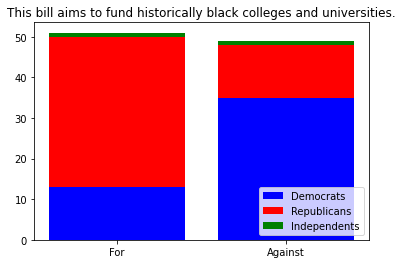

In [ ]:
educ_bill  = "This bill aims to fund historically black colleges and universities."
educ_votes = votesToDataFrame(predictBillVotes(educ_bill))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(educ_votes)

dataFrameToGraph(educ_votes, title = educ_bill)

,Name,Degree of belief,Vote,Party,State
0,Shelby,0.333306,Y,republican,Alabama
1,Tuberville,0.331309,Y,republican,Alabama
2,Murkowski,0.336084,Y,republican,Alaska
3,Sullivan,0.331895,Y,republican,Alaska
4,Kelly,0.332595,Y,democrat,Arizona
5,Sinema,0.332115,Y,democrat,Arizona
6,Boozman,0.343668,Y,republican,Arkansas
7,Cotton,0.331252,Y,republican,Arkansas
8,Feinstein,0.343099,Y,democrat,California
9,Padilla,0.343187,Y,democrat,California


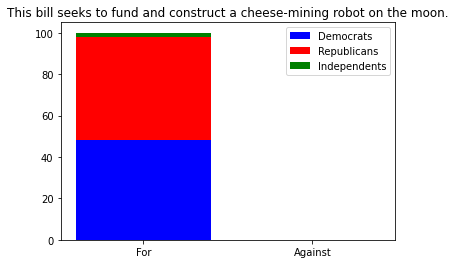

In [ ]:


cheese_bill  = "This bill seeks to fund and construct a cheese-mining robot on the moon."
cheese_votes = votesToDataFrame(predictBillVotes(cheese_bill))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cheese_votes)

dataFrameToGraph(cheese_votes, title = cheese_bill)

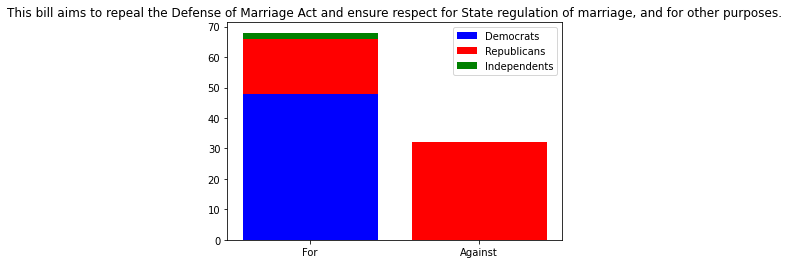

In [ ]:
respect_bill = "This bill aims to repeal the Defense of Marriage Act and ensure respect for State regulation of marriage, and for other purposes."
respect_votes = votesToDataFrame(predictBillVotes(respect_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(respect_votes)

dataFrameToGraph(respect_votes, title = respect_bill)

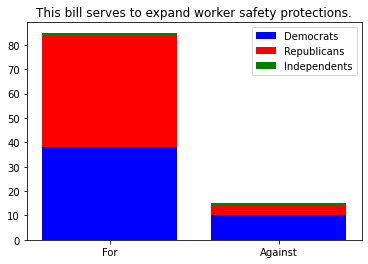

In [ ]:
safety_bill = "This bill serves to expand worker safety protections."
safety_votes = votesToDataFrame(predictBillVotes(safety_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(safety_votes)

dataFrameToGraph(safety_votes, title = safety_bill)

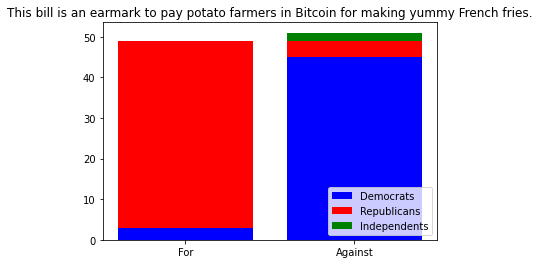

In [ ]:
potato_bill = "This bill is an earmark to pay potato farmers in Bitcoin for making yummy French fries."
potato_votes = votesToDataFrame(predictBillVotes(potato_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(potato_votes)

dataFrameToGraph(potato_votes, title = potato_bill)

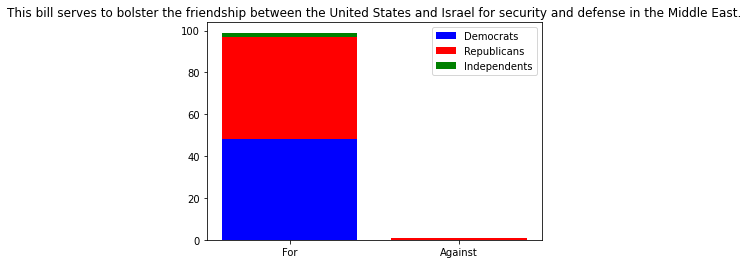

In [ ]:
mid_east_bill = "This bill serves to bolster the friendship between the United States and Israel for security and defense in the Middle East."
mid_east_votes = votesToDataFrame(predictBillVotes(mid_east_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(mid_east_votes)

dataFrameToGraph(mid_east_votes, title = mid_east_bill)

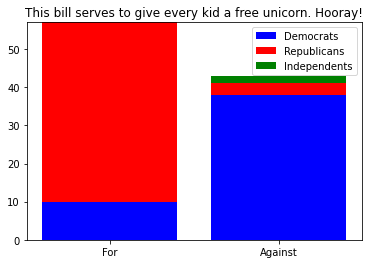

In [ ]:
unicorn_bill = "This bill serves to give every kid a free unicorn. Hooray!"
unicorn_votes = votesToDataFrame(predictBillVotes(unicorn_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(unicorn_votes)

dataFrameToGraph(unicorn_votes, title = unicorn_bill)

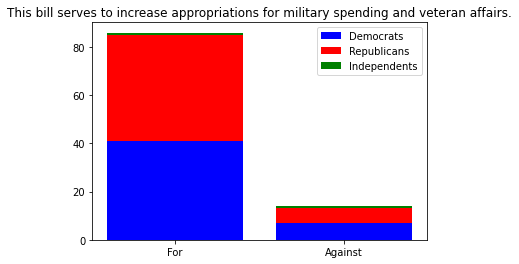

In [ ]:
mil_bill = "This bill serves to increase appropriations for military spending and veteran affairs."
mil_votes = votesToDataFrame(predictBillVotes(mil_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(mil_votes)

dataFrameToGraph(mil_votes, title = mil_bill)

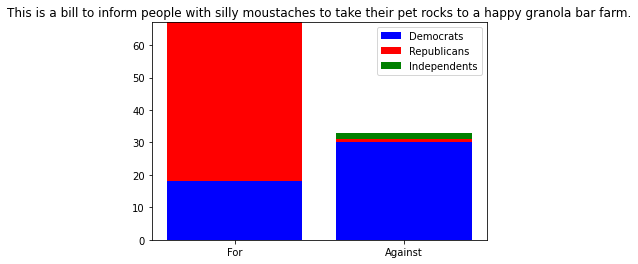

In [ ]:
silly_bill = "This is a bill to inform people with silly moustaches to take their pet rocks to a happy granola bar farm."
silly_votes = votesToDataFrame(predictBillVotes(silly_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(silly_votes)

dataFrameToGraph(silly_votes, title = silly_bill)

In [ ]:
# Download a zip file of our check point
!zip -r training_checkpoint_stuff.zip training_output/checkpoint-500/

  adding: training_output/checkpoint-500/ (stored 0%)
  adding: training_output/checkpoint-500/optimizer.pt (deflated 38%)
  adding: training_output/checkpoint-500/training_args.bin (deflated 49%)
  adding: training_output/checkpoint-500/scheduler.pt (deflated 49%)
  adding: training_output/checkpoint-500/trainer_state.json (deflated 69%)
  adding: training_output/checkpoint-500/config.json (deflated 47%)
  adding: training_output/checkpoint-500/rng_state.pth (deflated 27%)
  adding: training_output/checkpoint-500/pytorch_model.bin (deflated 8%)
